In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy import optimize

import funcs

### Problem 1
Standard error for m \& b from PS1.

In [2]:
# load in data
data = np.loadtxt('pset1_data.txt')
x, y, sigma_y, sigma_x, rho_xy = data.T

In [3]:
# same function used in PS1
def fit_a_line(x, y, sigma_y):
    # construct the matrices
    Y = y 
    A = np.column_stack((np.ones(len(Y)), x))
    C = np.diag(sigma_y**2)

    # we want to solve Y = A @ X, weighted by the covariance
    a = A.T @ np.linalg.solve(C, A)
    b = A.T @ np.linalg.solve(C, Y)

    # a X = b
    X = np.linalg.solve(a, b)

    # covariances
    cov = np.linalg.inv(a)

    return X, cov

In [4]:
# use the function defined above to get the best-fit parameters
[b1, m1], cov1 = fit_a_line(x[4:], y[4:], sigma_y[4:])
[b2, m2], cov2 = fit_a_line(x, y, sigma_y)

The direction of the error ellipse's major and minor axes is given by the eigenvectors of the covariance matrix, with length given by the eigenvalues.
The covariance matrix is
\begin{bmatrix}
\sigma^2_b  &   \sigma_{mb} \\
\sigma_{mb} &   \sigma^2_m
\end{bmatrix}

In [5]:
# eigenvalues and eigenvectors of the covariance matrices in the two cases we're looking at
w1, v1 = np.linalg.eig(cov1)
w2, v2 = np.linalg.eig(cov2)

In [6]:
# unpack values and vectors
w1b, w1m = w1
v1b, v1m = v1[:,0], v1[:,1]
w2b, w2m = w2
v2b, v2m = v2[:,0], v2[:,1]

In [7]:
# parametric equation for an ellipse
def ellipse(center, w, v):
    # v[0] = major axis eigenvector
    # v[1] = minor axis eigenvector
    thetas = np.arange(0, 2*np.pi, 0.01)
    ellipse = np.empty((len(thetas), 2))
    for i, theta in enumerate(thetas):
        x_comp = center[0] + np.sqrt(w[0])*v[1,0]*np.cos(theta) + np.sqrt(w[1])*v[1,1]*np.sin(theta)
        y_comp = center[1] + np.sqrt(w[0])*v[0,0]*np.cos(theta) + np.sqrt(w[1])*v[0,1]*np.sin(theta)
        ellipse[i] = [x_comp, y_comp]
    return ellipse

In [8]:
ellipse1 = ellipse([m1, b1], w1, v1)
ellipse2 = ellipse([m2, b2], w2, v2)

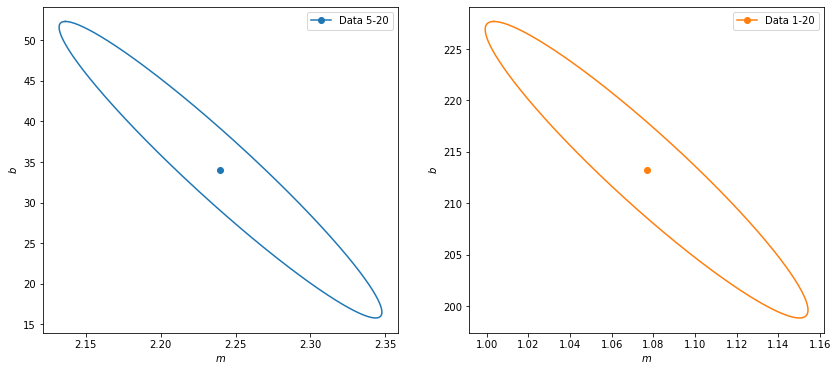

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].plot(m1, b1, marker='o', color='C0', label='Data 5-20')
axs[1].plot(m2, b2, marker='o', color='C1', label='Data 1-20')

axs[0].plot(ellipse1[:,0], ellipse1[:,1], color='C0')
axs[1].plot(ellipse2[:,0], ellipse2[:,1], color='C1')

for ax in axs:
    ax.set_xlabel('$m$')
    ax.set_ylabel('$b$')
    ax.autoscale_view()
    ax.legend()

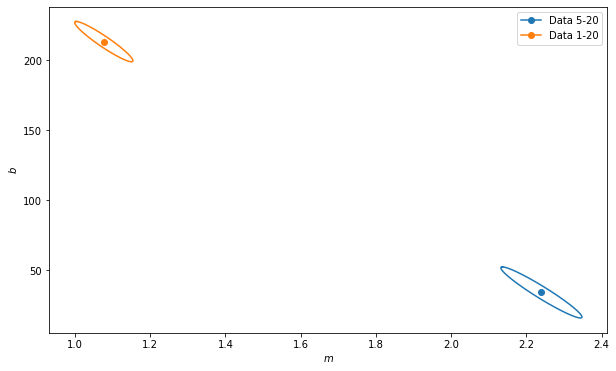

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(m1, b1, marker='o', color='C0', label='Data 5-20')
ax.plot(m2, b2, marker='o', color='C1', label='Data 1-20')
ax.plot(ellipse1[:,0], ellipse1[:,1], color='C0')
ax.plot(ellipse2[:,0], ellipse2[:,1], color='C1')

ax.set_xlabel('$m$')
ax.set_ylabel('$b$')
ax.autoscale_view()
ax.legend()

### Problem 2
Profile likelihood for PS1.

In [11]:
# load in the data
with open("pset2_data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

(13, 1024)


In [12]:
time = data[0]
sigmas = data[1]
signal = data[-1]

No handles with labels found to put in legend.


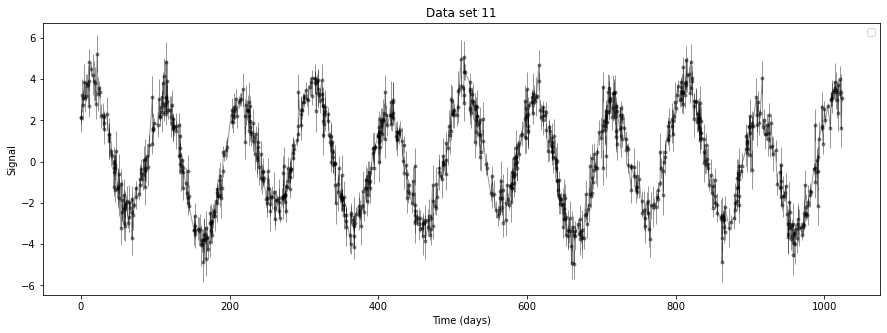

In [13]:
# plot data and fitted 100-day signal
fig, ax = plt.subplots(figsize=(15, 5))

ax.errorbar(time, signal, yerr=sigmas, lw=1, color='k', marker='.', alpha=0.4)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Signal')
ax.set_title(f'Data set 11')
ax.legend()

In [14]:
thissignal = funcs.Signal(time, signal, sigmas)

In [15]:
# profile out all other parameters
periods = np.logspace(1, 3, 100)
thissignal.find_second_period(T0=100, periods=periods)

Text(0.5, 1.0, 'Data set 11')

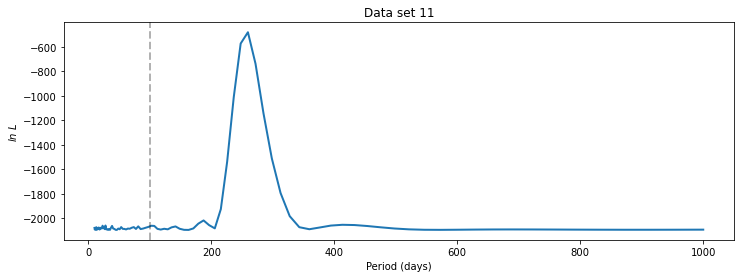

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(periods, thissignal.second_T_loglikes, lw=2)
ax.axvline(100, lw=2, color='k', alpha=0.3, ls='--')
ax.set_xlabel('Period (days)')
ax.set_ylabel('$ln\ L$')
ax.set_title(f'Data set 11')

We can get an estimate of the uncertainty in the period, $\sigma_T$, using the shape at the top of the parabola, fitting the three points around the peak to
$$
f(T) = -\frac{1}{2}aT^2 + bT + c
$$
From the Cramer-Rao bound,
$$
-f''(x) = \frac{1}{\sigma^2_T} \quad \Longrightarrow \quad \sigma_T = \frac{1}{\sqrt{a}}
$$
I'm just going to use scipy optimize for this.

In [17]:
# three points around the maximum likelihood
peak_idx = np.where(thissignal.second_T_loglikes==max(thissignal.second_T_loglikes))[0][0]

In [18]:
def parabola(x, a, b, c):
    return -0.5*a*x**2 + b*x + c

In [19]:
x = periods[peak_idx-1:peak_idx+2]
y = thissignal.second_T_loglikes[peak_idx-1:peak_idx+2]

In [20]:
fit_params, _ = optimize.curve_fit(parabola, x, y)
y_fit = parabola(periods, *fit_params)
a, b, c = fit_params
print(a, np.sqrt(a))

2.3739255084434574 1.5407548502092918


/Users/abbywilliams/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


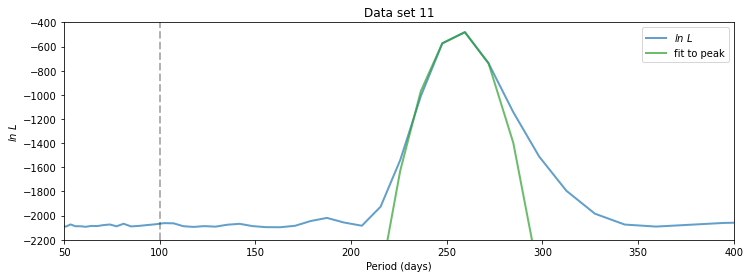

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(periods, thissignal.second_T_loglikes, color='C0', lw=2, alpha=0.7, label='$ln\ L$')
ax.plot(periods, y_fit, color='C2', lw=2, alpha=0.7, label='fit to peak')
ax.axvline(100, lw=2, color='k', alpha=0.3, ls='--')

ax.set_xlim((50,400))
ax.set_ylim((-2200,-400))
ax.set_xlabel('Period (days)')
ax.set_ylabel('$ln\ L$')
ax.set_title(f'Data set 11')
ax.legend()

### MCMC Problem 2
Simple Metropolis-Hastings MCMC sampler.

In [22]:
# general function for a M-H MCMC sampler, given a sample distribution, proposal distribution, number of hops and initial state
def MCMC(n, x, sample_dist, prop_dist):
    
    dim = 1 if type(x)==int or type(x)==float else len(x)

    states = np.empty((n, dim))

    current = x

    for i in range(n):
        # proposal PDF
        proposal = prop_dist(current)

        # draw random number from a uniform distribution
        rand_val = np.random.uniform()

        # evaluate the function to be sampled at both current and proposed vals
        p_current = sample_dist(current)
        p_proposal = sample_dist(proposal)

        # do we accept the proposal?
        # avoid division by zero– if p_current is zero, we automatically reject the proposal
        if p_current != 0:
            ratio = p_proposal/p_current
            if ratio > rand_val:
                current = proposal
        states[i] = current
    
    return states

In [23]:
# 1D Gaussian
def Gaussian(x, mu, sigma):
    exp = -0.5 * ((x-mu)/sigma)**2
    coeff = 1/(sigma*np.sqrt(2*np.pi))
    return coeff*np.e**exp

In [24]:
def gaussian_MCMC(n, x):

    def sample_dist(x):
        return Gaussian(x, mu=2, sigma=np.sqrt(2))
    
    def prop_dist(x):
        return np.random.normal(loc=x, scale=1)

    states = MCMC(n, x, sample_dist=sample_dist, prop_dist=prop_dist)
    
    return states

In [25]:
# initialize the chain with x=0, and do 100,000 hops
x = 0
n = 100000
states = gaussian_MCMC(n=n, x=x)

Text(0, 0.5, 'Counts')

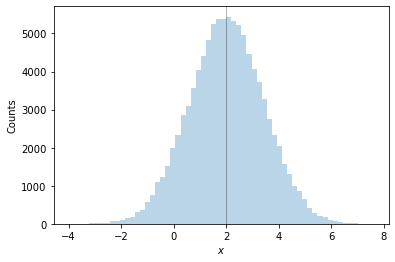

In [26]:
# histogram of the raw counts
fig, ax = plt.subplots()
vals, bins, _ = ax.hist(states, bins=60, alpha=0.3)
ax.axvline(2, color='k', alpha=0.3, lw=1)
ax.set_xlabel('$x$')
ax.set_ylabel('Counts')

In [27]:
# normalize these output histogram values
binwidth = bins[1]-bins[0]
vals_norm = vals/(np.sum(vals)*binwidth)

In [28]:
# midpoints of the bins
x = np.array([0.5*(bins[i+1]+bins[i]) for i in range(len(vals))])

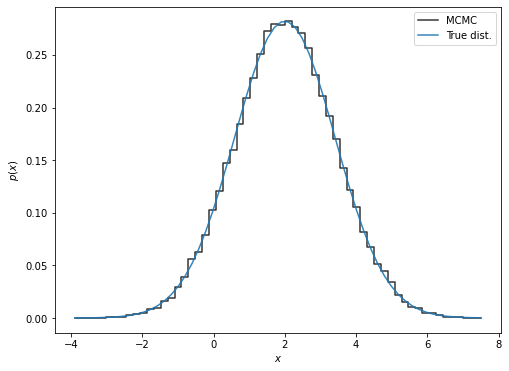

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

ax.step(x, vals_norm, where='mid', color='k', alpha=0.8, label='MCMC')

ax.plot(x, Gaussian(x, mu=2, sigma=np.sqrt(2)), color='C0', alpha=0.9, label='True dist.')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.legend()

### MCMC Problem 4
Re-do Problem 2 but in two dimensions.

#### Gaussian

In [30]:
# 2D Gaussian
def Gaussian_2D(x, mu, cov):
    A = np.array(x)-np.array(mu)
    exp = -0.5 * A.T @ np.linalg.solve(cov, A)
    coeff = 1/np.sqrt(2*np.pi*np.linalg.det(cov))
    return coeff * np.e**exp

In [37]:
def gaussian_2D_MCMC(n, x, cov):

    def sample_dist(x):
        return Gaussian_2D(x, mu=[0,0], cov=cov)
    
    def prop_dist(x):
        return np.random.multivariate_normal(mean=x, cov=np.identity(2))

    states = MCMC(n, x, sample_dist=sample_dist, prop_dist=prop_dist)
    
    return states

In [38]:
# run the chain with an initial value x=(0,0), given covariance matrix, and do 100,000 hops
x = np.array([0,0])
cov = np.array([[2.0, 1.2], [1.2, 2.0]])
n = 100000
states = gaussian_2D_MCMC(n=n, x=x, cov=cov)

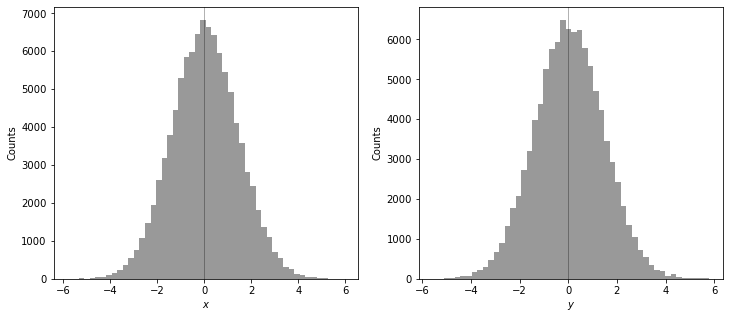

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

labels = ['$x$', '$y$']

for i, ax in enumerate(axs):
    _, _, _ = ax.hist(states[:,i], color='k', bins=50, alpha=0.4)
    ax.axvline(0, color='k', lw=1, alpha=0.3)
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Counts')

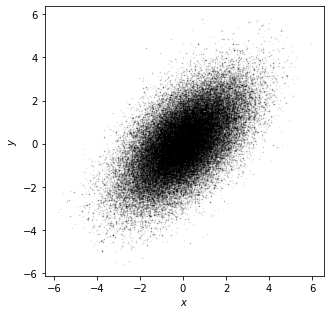

In [40]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(states[:,0], states[:,1], color='k', marker='.', s=1, alpha=0.1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

#### Top-hat

In [41]:
# simple tophat function: return 1 if the given value is within the x and y bounds, otherwise return 0
def tophat(val, xbnds, ybnds):
    xmin, xmax = xbnds
    ymin, ymax = ybnds

    if val[0] > xmin and val[0] < xmax:
        if val[1] > ymin and val[1] < ymax:
            return 1
        else:
            return 0
    else:
        return 0

In [44]:
def tophat_2D_MCMC(n, x, xbnds, ybnds):

    def sample_dist(x):
        return tophat(x, xbnds, ybnds)
    
    def prop_dist(x):
        return np.random.multivariate_normal(mean=x, cov=np.identity(2))

    states = MCMC(n, x, sample_dist=sample_dist, prop_dist=prop_dist)
    
    return states

In [45]:
# run this chain with an initial value of x=(5,5) (lazily in ~middle of the x and y bounds), and do 100,000 hops
x = np.array([5,5])
n = 100000
xbnds = [3,7]
ybnds = [1,9]
states = tophat_2D_MCMC(n=n, x=x, xbnds=xbnds, ybnds=ybnds)

In [46]:
# true distribution (for plotting); x and y components separately
x = np.arange(0,10,0.01)
y = x

true_dist_x = np.array([tophat(val, xbnds, ybnds=[0,10]) for val in np.array([x,y]).T])
true_dist_y = np.array([tophat(val, xbnds=[0,10], ybnds=ybnds) for val in np.array([x,y]).T])

# normalize by the area under the curve
true_dists = np.array([true_dist_x/(xbnds[1]-xbnds[0]), true_dist_y/(ybnds[1]-ybnds[0])])

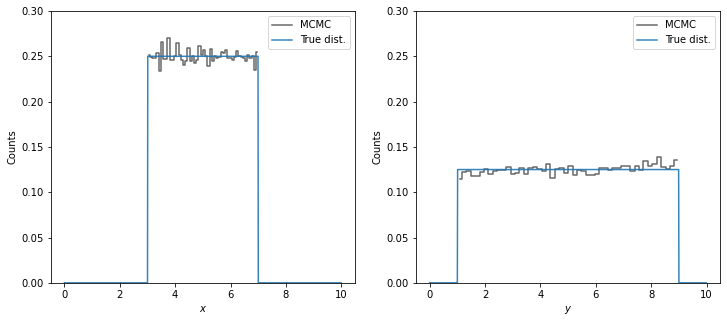

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

labels = ['$x$', '$y$']

for i, ax in enumerate(axs):
    vals, bins = np.histogram(states[:,i], bins=50)
    x_bins = np.array([0.5*(bins[i+1]+bins[i]) for i in range(len(vals))])
    binwidth = bins[1]-bins[0]
    vals_norm = vals/np.sum(vals)/binwidth
    ax.step(x_bins, vals_norm, where='mid', color='k', alpha=0.6, label='MCMC')

    ax.plot(x, true_dists[i], color='C0', alpha=0.9, label='True dist.')
    ax.set_ylim((0,0.3))
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Counts')
    ax.legend()

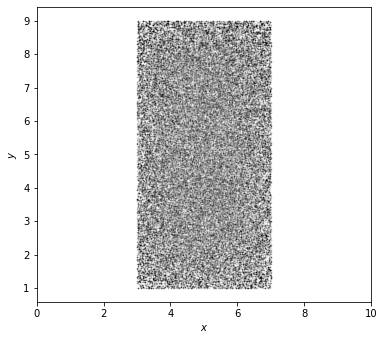

In [48]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(states[:,0], states[:,1], color='k', marker='.', s=1, alpha=0.1)
ax.set_xlim((0,10))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

### MCMC Problem 10
Re-do Problem 2, looking at convergence.

In [49]:
x = 0
n = 100000
states = gaussian_MCMC(n=n, x=x)

In [50]:
# split this chain into four contiguous segments
quarter = n/4

Text(0, 0.5, '$x$')

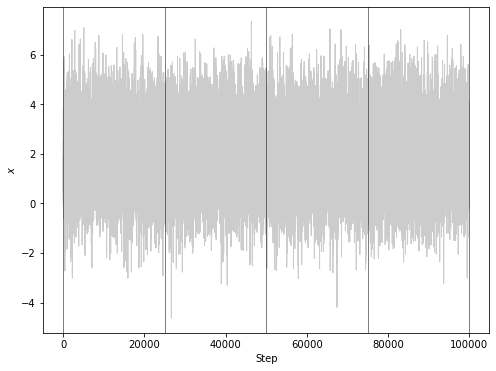

In [51]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(states, lw=1, color='k', alpha=0.2)
for i in range(5):
    ax.axvline(quarter*i, color='k', lw=1, alpha=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('$x$')

In [52]:
# heuristics in each quarter
quarters = np.array([states[int(quarter*i):int(quarter*(i+1))] for i in range(4)]).squeeze()
quarters.shape

(4, 25000)

In [53]:
for i, set in enumerate(quarters):
    mean = np.mean(set)
    var = np.std(set)**2
    print(f"Quarter {i}: \n Empirical mean = {mean:.2f} \n Empirical variance = {var:.2f}")

Quarter 0: 
 Empirical mean = 1.96 
 Empirical variance = 2.02
Quarter 1: 
 Empirical mean = 2.00 
 Empirical variance = 1.94
Quarter 2: 
 Empirical mean = 1.97 
 Empirical variance = 2.10
Quarter 3: 
 Empirical mean = 2.01 
 Empirical variance = 1.94


From these heuristics, I conclude that the chain converges fairly quickly—clearly in the first quarter, because the means and variances remain fairly constant across all four quarters.